Install Required Packages

In [15]:
import os
import time
import pandas as pd
from google_play_scraper import reviews, Sort
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt

TextBlob Sentiment Analysis

In [7]:
# Dictionary mapping bank names to their Google Play app IDs
banks = {
    "Commercial Bank of Ethiopia": "com.combanketh.mobilebanking",
    "Bank of Abyssinia": "com.boa.boaMobileBanking",
    "Dashen Bank": "com.dashen.dashensuperapp"
}
# Function to classify sentiment using TextBlob
def classify_sentiment_textblob(text):
    polarity = TextBlob(str(text)).sentiment.polarity
    if polarity > 0.05:
        return 'Positive'
    elif polarity < -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    # Function to scrape and extract relevant review data
def scrape_reviews(app_id, bank_name, num_reviews=400):
    all_reviews = []
    token = None

    while len(all_reviews) < num_reviews:
        batch, token = reviews(
            app_id,
            lang='en',
            country='et',
            sort=Sort.NEWEST,
            count=200,
            continuation_token=token
        )
        all_reviews.extend(batch)
        if not token:
            break
        time.sleep(1)
         # Extract and format required fields
    data = []
    for r in all_reviews[:num_reviews]:
        data.append({
            'review': r['content'],
            'rating': r['score'],
            'date': r['at'].strftime('%Y-%m-%d'),
            'bank': bank_name,
            'source': 'Google Play'
        })

    return pd.DataFrame(data)
# Scrape reviews for all banks
all_dfs = []
for bank, app_id in banks.items():
    print(f"🔍 Scraping {bank}...")
    df = scrape_reviews(app_id, bank)
    all_dfs.append(df)

🔍 Scraping Commercial Bank of Ethiopia...
🔍 Scraping Bank of Abyssinia...
🔍 Scraping Dashen Bank...


In [8]:
# Combine and clean
final_df = pd.concat(all_dfs, ignore_index=True)
final_df.drop_duplicates(subset=["review", "bank"], inplace=True)
final_df.dropna(subset=["review", "rating", "date"], inplace=True)

In [9]:
# Apply TextBlob sentiment classification
final_df['sentiment'] = final_df['review'].apply(classify_sentiment_textblob)

In [10]:
# Save result
os.makedirs("data", exist_ok=True)
final_df.to_csv("data/bank_reviews_sentiment_textblob.csv", index=False)

In [11]:
print("✅ Sentiment analysis complete using TextBlob.")
print("📁 Saved to 'data/bank_reviews_sentiment_textblob.csv'")
print(final_df[['bank', 'review', 'sentiment']].head())

✅ Sentiment analysis complete using TextBlob.
📁 Saved to 'data/bank_reviews_sentiment_textblob.csv'
                          bank  \
0  Commercial Bank of Ethiopia   
1  Commercial Bank of Ethiopia   
2  Commercial Bank of Ethiopia   
3  Commercial Bank of Ethiopia   
5  Commercial Bank of Ethiopia   

                                              review sentiment  
0                       Best Mobile Banking app ever  Positive  
1                                               good  Positive  
2  it was good app but it have some issues like i...  Positive  
3                                              dedeb   Neutral  
5                                               Good  Positive  


<Axes: xlabel='bank', ylabel='count'>

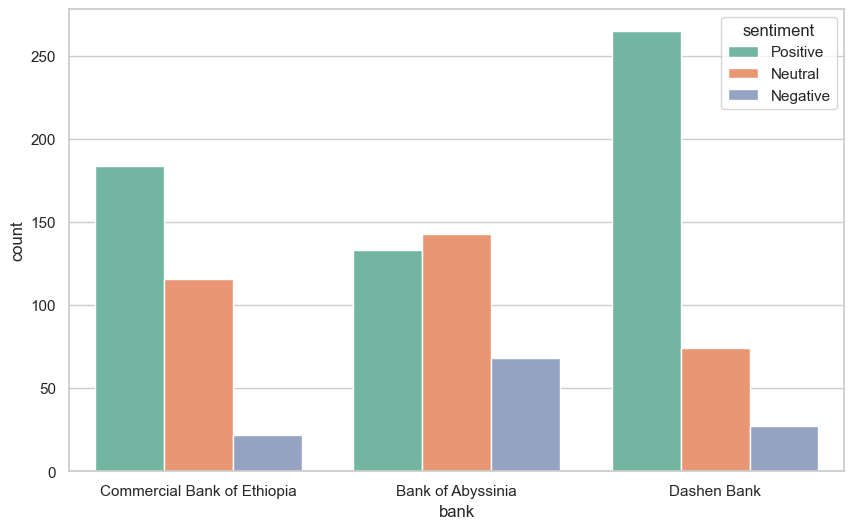

In [18]:
# Load sentiment-labeled reviews
df = pd.read_csv("data/bank_reviews_sentiment_textblob.csv")  # or use sentiment_vader.csv
# Set Seaborn style
sns.set(style="whitegrid")
# Create a count plot of sentiments per bank
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bank', hue='sentiment', palette='Set2')

C:\Users\USED\AppData\Local\Temp\ipykernel_13684\3838847961.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Sentiment")


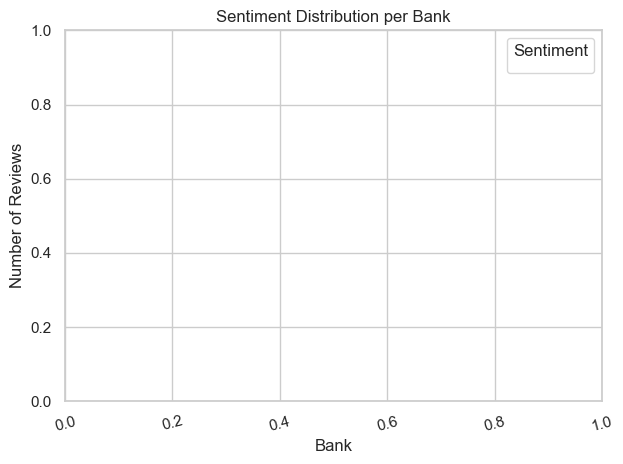

In [19]:
# Customize plot
plt.title("Sentiment Distribution per Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=15)
plt.legend(title="Sentiment")
plt.tight_layout()